In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial import distance_matrix
from scipy.spatial import distance
from sklearn.decomposition import PCA
import seaborn as sns
import time
from tqdm import tqdm

In [ ]:
test = pd.read_csv("/content/MNIST_test_small.csv")
x_test = test.iloc[:,1:].values
y_test = test.iloc[:,0].values
x_test_normalized= pd.DataFrame(np.apply_along_axis(
    lambda x: 0.0 if x_test.max ()== 0.0 else x/x_test.max() , 0, x_test))

train = pd.read_csv("/content/MNIST_train_small.csv")
x_train = train.iloc[:,1:]
y_train = train.iloc[:,0]
x_train_normalized= pd.DataFrame(np.apply_along_axis(
    lambda x: np.zeros(x.shape[ 0]) if x.max()== 0.0 else np.divide(x,x.max()) , 0, x_train.values))

train_big = pd.read_csv("/content/MNIST_train.csv")
x_train_big = train_big.iloc[:,1:]
y_train_big = train_big.iloc[:,0]
x_train_big_normalized= pd.DataFrame(np.apply_along_axis(
    lambda x: 0.0 if x_train_big.values.max()== 0.0 else x/x_train_big.values.max() , 0, x_train_big.values ))

test_big = pd.read_csv("/content/MNIST_test.csv")
x_test_big = test_big.iloc[:,1:]
y_test_big = test_big.iloc[:,0]
x_test_big_normalized= pd.DataFrame(np.apply_along_axis(lambda x: 0.0 if x_test_big.values.max()== 0.0 else x/x_test_big.values.max() , 0, x_test_big.values))

In [ ]:
# mode function
def mode(array):
  '''
In case of ties we are choosing the value of the nearest neighbor:
that is because .argmax() return the first item encountered in the array, that will be by definition the nearest one
'''
  val, cnts = np.unique(array, return_counts=True)
  return val[cnts.argmax()], cnts.max()

def manhattan_matrix(X1, X2, p=0):
  return distance.cdist(X1, X2, 'cityblock')

def chebyshev_matrix(X1, X2, p=0):
  return distance.cdist(X1, X2, 'chebyshev')

def mahalanobis_matrix(X1, X2, p=0):
  return distance.cdist(X1, X2, 'mahalanobis', VI=None)

def cosine_dist(X1, X2, p=0):
  mat = np.dot(np.array(X2).T,np.array(X1))
  return 2 - 2*mat.T

def minkowski_dist(v, w, p = 2):
  D = np.abs(np.subtract(w, v))
  Dp = np.power(D, p)
  distance_vals = np.sum(Dp, axis = 0)
  distance_vals_p = np.power(distance_vals, 1 / p)
  return distance_vals_p

In [ ]:
class KNN():

  def __init__(self, p=2, distance='minkowski', distance_f=minkowski_dist):
    self.p = p
    self.distance_f = distance_f 
    if(display=='manhattan'):
      self.distance = 'manhattan'
      self.distance_matrix = manhattan_matrix 
    elif(distance=='chebyshev'):
      self.distance = 'chebyshev'
      self.distance_matrix = chebyshev_matrix 
    else:
      self.distance = 'minkowski'
      self.distance_matrix = distance_matrix
    pass

  def fit(self, X, y, k_max, p_array=[2] ): 
    """
    Fit on training data
    X: x_train dataset
    Y: y_train
    """
    self.x_train = X
    self.y_train = y
    self.n_training = X.shape[0]
    self.classes = np.unique(y)
    self.k_neigh_mtx = self.create_k_matrix(k_max)
    self.k_neigh_mtx = self.k_neigh_mtx.reshape(self.k_neigh_mtx.shape[0], 
    self.k_neigh_mtx.shape[1])
    pass

  def __str__(self):
    return 'Knn with distance parameter p = {}'.format(self.p)

  def __repr__(self): 
    return self.__str__()

  def loss(self, y1, y2):
    return y1 != y2

  def create_k_matrix(self, k):
    '''
    Reduce the matrix for the cross validation by considering only k smal
    lest values
    '''
    return np.apply_along_axis(lambda x: np.argsort(self.distance_matrix(self.x_train.values, [x], p=self.p), axis=0)[:k],1, self.x_train.values)


  def cross_validate(self, k, n_fold='loocv'): 
    """
    k_max : number of maximum to consider n_fold : fold of cross validation.
    if n_fold='loocv' it will just use the leave-one-out cross validation where n_fold= # training samples
    """
    if n_fold == 'loocv':
      loss_ipk = [self.predict_train(i, k) for i in range(self.n_training)]
      loss_cv = np.mean(loss_ipk, axis=0)
    return loss_cv

  def predict_train(self, i, k):
    y_pred = mode(self.y_train[self.k_neigh_mtx[i, 1:(k+1)]])[0]
    y_loss = self.loss(y_pred, self.y_train[i])
    return y_loss 


  def predict(self, x_test, k_array): 
    """
    Predict class for the given observation
    x_test: new observations to predict
    k_array: array of k number of neighbors to consider 
    """
    kmax_neigh = np.apply_along_axis(
              lambda x: np.argsort(self.distance_matrix(self.x_train.values, [x], p=self.p), axis=0)[:np.max(k_array)],1, x_test)
    kmax_neigh = np.squeeze(kmax_neigh, axis=2)
    return [np.apply_along_axis(lambda neigh: mode(self.y_train[neigh[:k]])[0], 1, kmax_neigh) for k in k_array]

  def compute_loss(self, x_test, y_test, k_array):
      """
      Score function: predict the values and compare to the real values given
      x_test: input value to predict
      y_test: real value of output
      k_array: array of k number of neihbors to consider
      """
      predictions = self.predict(x_test, k_array)
      losses = [self.loss(predictions[kidx],y_test).sum()/y_test.shape[0] for kidx, k in enumerate(k_array)]
      return dict(zip(k_array, losses))



A)

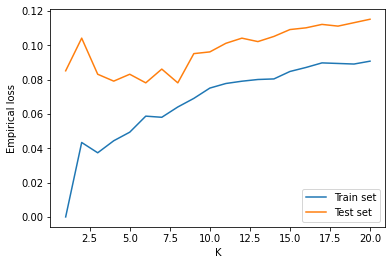

In [ ]:
kmax=21
knn_a = KNN()
knn_a.fit(x_train,y_train, k_max=kmax-1)

train_loss_a = knn_a.compute_loss(x_train, y_train, np.arange(1,kmax))
test_loss_a = knn_a.compute_loss(x_test, y_test, np.arange(1,kmax))

#plot train_score and test_score
plt.xlabel('K')
plt.ylabel('Empirical loss')
plt.plot(*zip(*sorted(train_loss_a.items())), label="Train set")
plt.plot(*zip(*sorted(test_loss_a.items())), label="Test set")
plt.legend()
plt.show()

B)

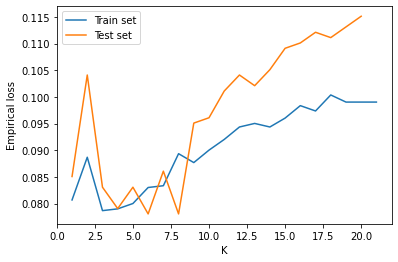

In [ ]:
#B
kmax = 21
knn_b = KNN()
knn_b.fit(x_train,y_train, k_max=kmax-1)
k_array = np.arange(1,kmax+1)
train_loss_b = dict(zip(k_array, [knn_b.cross_validate(k) for k in k_array]))

#plot train_score_crossVal and test_score
plt.xlabel('K')
plt.ylabel('Empirical loss')
plt.plot(*zip(*sorted(train_loss_b.items())), label="Train set")
plt.plot(*zip(*sorted(test_loss_a.items())), label="Test set")
plt.legend()
plt.show()

C)

In [ ]:
#C
pmin=1
pmax=16
kmax=21
crossValScore = []
k_array = np.arange(1,kmax-1)

for p in np.arange(pmin,pmax): 
  knn_c = KNN(p=p)
  knn_c.fit(x_train, y_train, k_max=kmax)
  crossValScore.append(dict(zip(k_array, [knn_c.cross_validate(k) for k in k_array])))

crossValScore = pd.DataFrame(crossValScore)

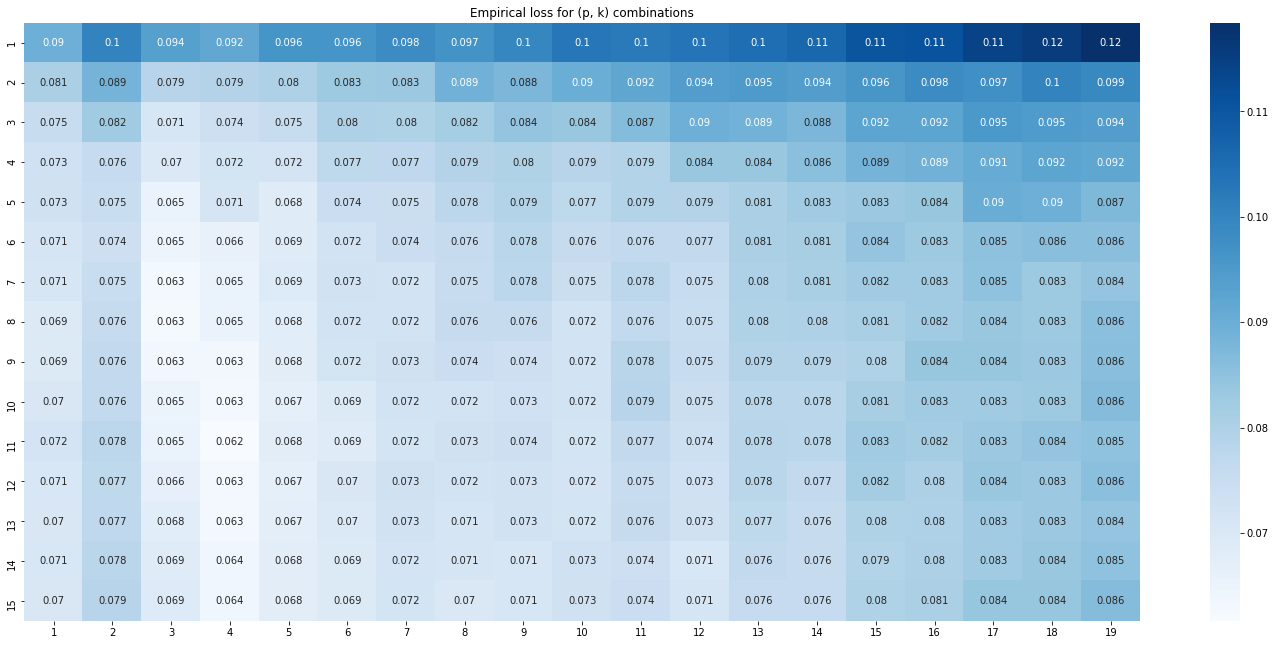

In [ ]:
fig, ax = plt.subplots(figsize=(25,11))
ax.set_title("Empirical loss for (p, k) combinations")
sns.heatmap(crossValScore, ax=ax, annot=True, cmap='Blues', xticklabels='auto', yticklabels=np.arange(1, 16))

D)

In [ ]:
k_array = np.arange(2,21)

knn_d_euclidean = KNN()
knn_d_euclidean.fit(x_train, y_train, k_max=20)
crossValScore_euclidean = dict(zip(k_array, [knn_d_euclidean.cross_validate(k) for k in k_array]))

knn_d_bestMinkowski = KNN(p=11)
knn_d_bestMinkowski.fit(x_train, y_train, k_max=20)
crossValScore_bestMinkowski = dict(zip(k_array, [knn_d_bestMinkowski.cross_validate(k) for k in k_array]))

knn_d_manhattan = KNN(distance='manhattan')
knn_d_manhattan.fit(x_train, y_train, k_max=20)
crossValScore_manhattan = dict(zip(k_array, [knn_d_manhattan.cross_validate(k) for k in k_array]))

knn_d_chebyshev = KNN(distance='chebyshev')
knn_d_chebyshev.fit(x_train, y_train, k_max=20)
crossValScore_chebyshev = dict(zip(k_array, [knn_d_chebyshev.cross_validate(k) for k in k_array]))

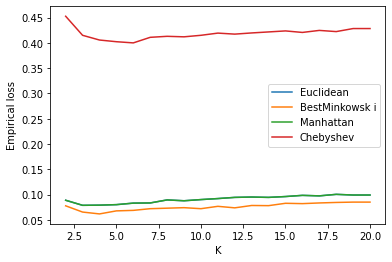

In [ ]:
plt.xlabel('K')
plt.ylabel('Empirical loss') 

plt.plot(*zip(*sorted(crossValScore_euclidean.items())), label="Euclidean")
plt.plot(*zip(*sorted(crossValScore_bestMinkowski.items())), label="BestMinkowsk i")
plt.plot(*zip(*sorted(crossValScore_manhattan.items())), label="Manhattan")
plt.plot(*zip(*sorted(crossValScore_chebyshev.items())), label="Chebyshev")
plt.legend()
plt.show()

Processing with different filters.

In [ ]:
def imageFilter(data,method): 
  '''
  Preprocessing:
  data -> np.array image or datasets of images method:
  1. Gaussian: a Gaussian kernel is used: Gaussian filtering is highly ef fective in removing Gaussian noise from the image.
  2. Median: median of all the pixels under the kernel window and the cent ral pixel
  is replaced with this median value.
  '''
  if method == 'gaussian':
    return np.apply_along_axis(lambda img: cv2.GaussianBlur(img.astype(dtype =np.uint8).reshape(28,-1),(5,5),0).flatten(),1,data)
  if method =='averaging':
    kernel = np.ones((5,5),np.float32)/25
  return np.apply_along_axis(lambda img: cv2.filter2D(img.astype(dtype=np.uint8).reshape(28,-1),-1,kernel).flatten(),1,data)

In [ ]:
knn = KNN(p=11)
k_array = np.arange(2,21)

start = time.time()
knn.fit(train_gaussian, y_train, k_max=20)
score_gaussian = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('GaussianBlurring preprocessing:',time.time()-start)

start = time.time()
knn.fit(train_averaging, y_train, k_max=20)
score_median = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('Averaging kernel preprocessing:',time.time()-start)

start = time.time()
knn.fit(x_train, y_train, k_max=20)
score_normal = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('No preprocessing:',time.time()-start)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

knn = KNN(p=11)
k_array = np.arange(1,21)


x_train_n = pd.DataFrame(MinMaxScaler().fit_transform(x_train))

start = time.time()
knn.fit(x_train_n, y_train, k_max=20)
norm_score = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('Normalized data:',time.time()-start)

start = time.time()
knn.fit(x_train, y_train, k_max=20)
score = dict(zip(k_array, [knn.cross_validate(k) for k in k_array]))
print('Not normalized data:',time.time()-start)

Normalized data: 299.67195534706116
Not normalized data: 299.2555606365204


In [ ]:
mnist_pca = PCA(n_components=0.90) #90% of variability is captured by those PC mnist_pca.fit(x_train)
components = mnist_pca.transform(x_train)
test = mnist_pca.transform(x_test)